<a href="https://colab.research.google.com/github/MuhammadBinTariq/ATML_PA0/blob/main/Task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 4: Training Variational Autoencoders

In [ ]:
import torch
import architecture
from torchvision.transforms import ToTensor
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

In [ ]:
# Downloading the FashionMNIST dataset
trainset = FashionMNIST(root='./FashionMNIST', download=True, train=True, transform=ToTensor())
testset = FashionMNIST(root='./FashionMNIST', download=True, train=False, transform=ToTensor())

train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(testset, batch_size=64)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def VAE_loss(x, x_recon, mu, log_var):
    # Reconstruction Loss as MSE
    recon_loss = torch.nn.functional.mse_loss(x, x_recon, reduction='sum')

    # KL Div.
    KL_div = 0.5 * torch.sum((mu ** 2) + torch.exp(log_var) - log_var - 1)

    total_loss = recon_loss + KL_div

    return total_loss, recon_loss, KL_div


def train_vae(model, dataloader, optimizer, epochs=10):
    model.to(device)
    train_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_recon = 0
        total_kl = 0

        for images, _ in dataloader:
            images = images.to(device)

            # Forward pass
            x_recon, mu, log_var = model(images)
            loss, r_loss, kl_loss = VAE_loss(images, x_recon, mu, log_var)

            # Backpropograte loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate losses
            total_loss += loss.item()
            total_recon += r_loss.item()
            total_kl += kl_loss.item()

        avg_loss = total_loss / len(dataloader.dataset)
        avg_recon = total_recon / len(dataloader.dataset)
        avg_kl = total_kl / len(dataloader.dataset)

        print(f'Epoch [{epoch+1}/{epochs}], Total Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}')
        train_losses.append(avg_loss)

    return train_losses


def test_vae(model, dataloader):
    model.to(device)
    model.eval()

    total_loss = 0
    total_recon = 0
    total_kl = 0

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            x_recon, mu, logvar = model(images)
            loss, recon_loss, kl_loss = VAE_loss(images, x_recon, mu, logvar)

            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()

    avg_loss = total_loss / len(dataloader.dataset)
    avg_recon = total_recon / len(dataloader.dataset)
    avg_kl = total_kl / len(dataloader.dataset)

    print(f'Test Results: Total Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}')
    return avg_loss, avg_recon, avg_kl

In [ ]:
# Initialize model and optimizer
model = architecture.VAE(latent_dim=20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# Train the model
train_losses = train_vae(model, train_loader, optimizer, epochs=10)

# Test the model
test_loss, test_recon, test_kl = test_vae(model, test_loader)

Epoch [1/10], Total Loss: 34.4268, Recon: 28.1571, KL: 6.2697
Epoch [2/10], Total Loss: 26.2184, Recon: 19.2331, KL: 6.9853
Epoch [3/10], Total Loss: 25.1841, Recon: 17.9184, KL: 7.2658
Epoch [4/10], Total Loss: 24.6568, Recon: 17.2307, KL: 7.4260
Epoch [5/10], Total Loss: 24.2972, Recon: 16.7413, KL: 7.5559
Epoch [6/10], Total Loss: 24.0617, Recon: 16.4342, KL: 7.6274
Epoch [7/10], Total Loss: 23.8921, Recon: 16.1898, KL: 7.7023
Epoch [8/10], Total Loss: 23.7386, Recon: 16.0062, KL: 7.7324
Epoch [9/10], Total Loss: 23.6256, Recon: 15.8678, KL: 7.7579
Epoch [10/10], Total Loss: 23.5198, Recon: 15.7180, KL: 7.8018
Test Results: Total Loss: 23.6154, Recon: 15.0832, KL: 8.5322


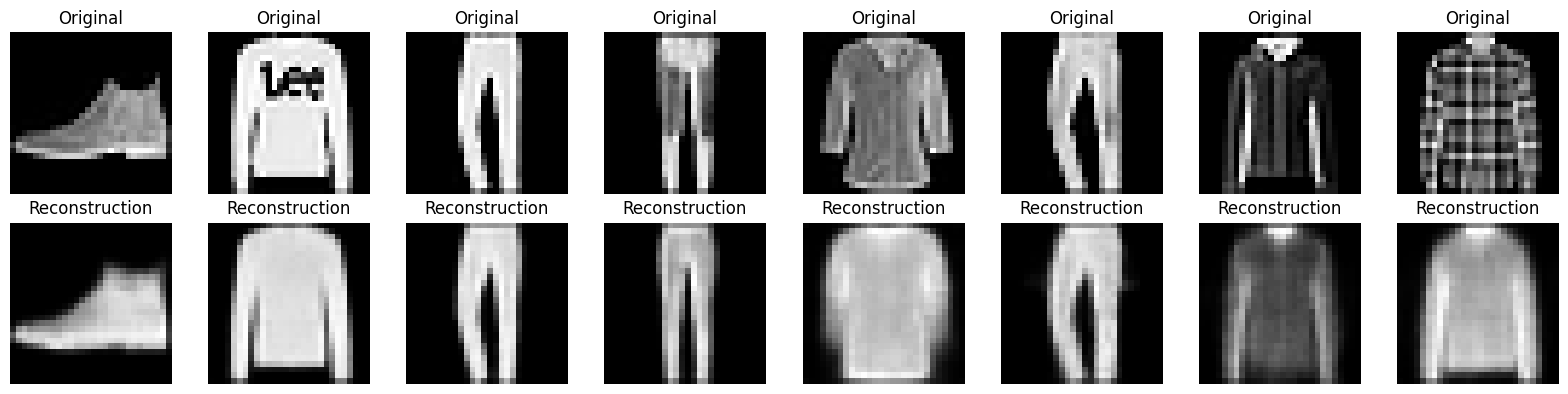

In [ ]:
import matplotlib.pyplot as plt

def visualize_reconstructions(model, dataloader, num_samples=8):
    model.eval()
    images, labels = next(iter(dataloader)) # Get one batch

    # Forward pass only
    with torch.no_grad():
        images = images.to(device)
        reconstructions, _, _ = model(images) # Get reconstructions
        reconstructions = reconstructions.cpu() # Move back to CPU for plotting

    # Plotting
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples*2, 4))
    for i in range(num_samples):
        # Plot original images
        axes[0, i].imshow(images[i].squeeze().cpu().numpy(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')

        # Plot reconstructed images
        axes[1, i].imshow(reconstructions[i].squeeze().numpy(), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstruction')

    plt.tight_layout()
    plt.show()

# Usage
visualize_reconstructions(model, test_loader)

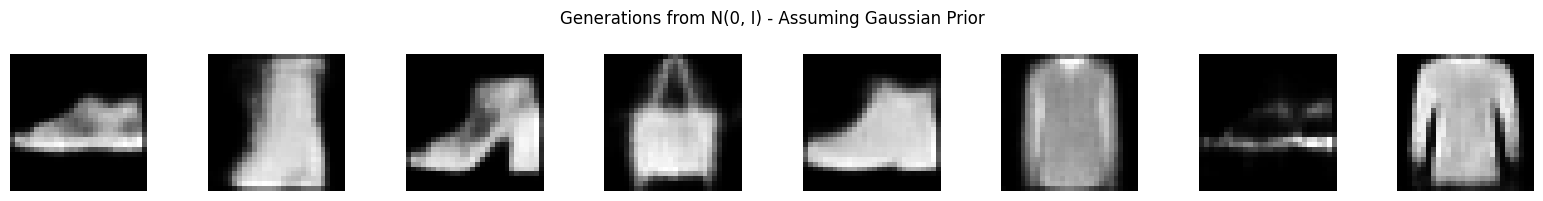

In [ ]:
import matplotlib.pyplot as plt

def visualize_generations(model, num_samples=8, latent_dim=20):
    # Visualizing generations from sampling latent from the learned prior
    model.eval()
    with torch.no_grad():
        # z = torch.randn(num_samples, latent_dim).to(device)
        # Try these and compare the results visually
        z = torch.randn(8, latent_dim).to(device)          # Original: N(0, 1) - Good
        # z = (torch.randn(8, latent_dim).to(device) + 2)    # Shifted: N(2, 1) - Might be slightly worse
        # z = (torch.randn(8, latent_dim).to(device) * 0.2)  # Scaled: N(0, 0.04) - Might be more blurred
        generated_imgs = model.decode(z).cpu()

    # Plotting
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples*2, 2))
    for i in range(num_samples):
        axes[i].imshow(generated_imgs[i].squeeze().numpy(), cmap='gray')
        axes[i].axis('off')

    plt.suptitle('Generations from N(0, I) - Assuming Gaussian Prior')
    plt.tight_layout()
    plt.show()

# Usage
visualize_generations(model, latent_dim=20)

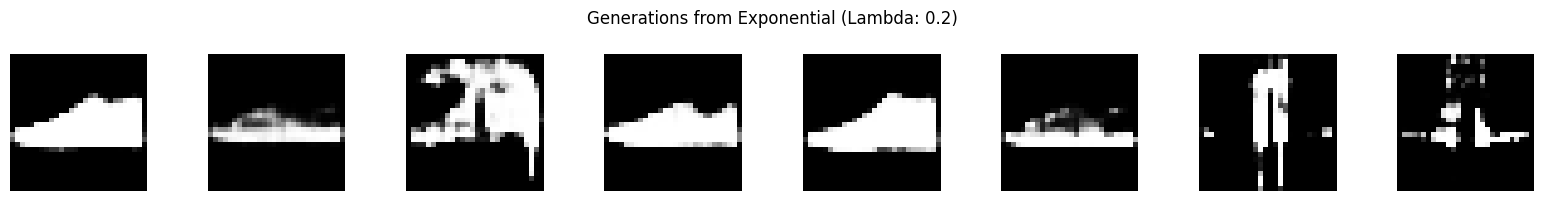

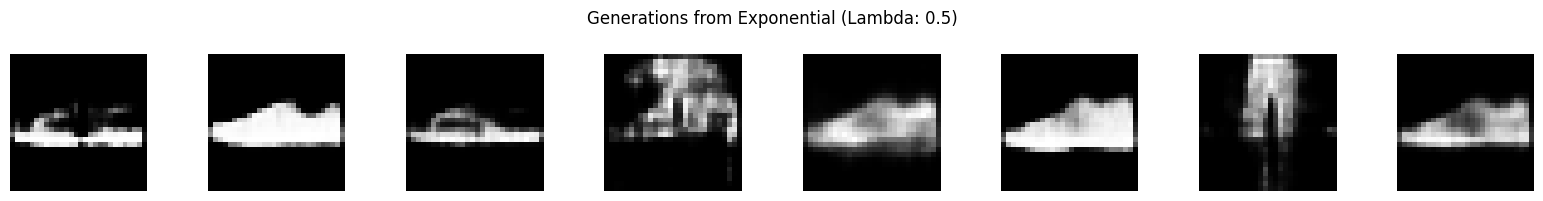

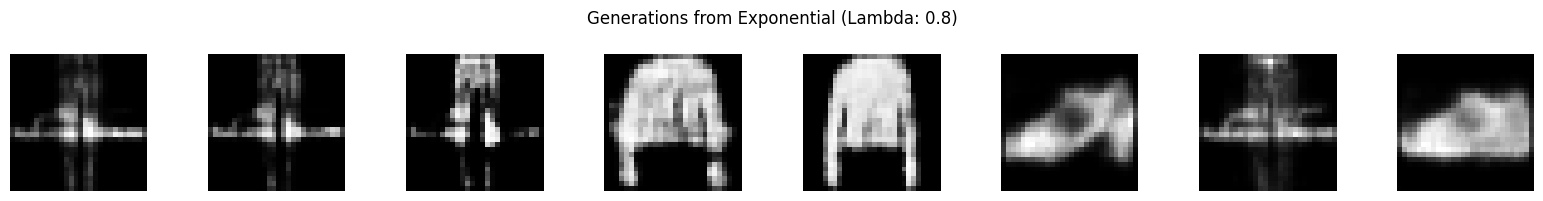

In [ ]:
def visualize_exponential_prior(model, num_samples=8, latent_dim=20, factor=2.0):
    # Tweak sampling from a different prior for fun
    model.eval()
    with torch.no_grad():
        # Sample from a *different* prior: e.g., a wider Gaussian N(0, 4)
        # z = torch.randn(num_samples, latent_dim).to(device) * factor
        # generated_imgs = model.decode(z).cpu()

        # z = torch.distributions.laplace.Laplace(0, 1).sample((num_samples, latent_dim)).to(device)
        z = torch.distributions.exponential.Exponential(factor).sample((num_samples, latent_dim)).to(device)
        generated_imgs = model.decode(z).cpu()

        # # Using torch.distributions (requires PyTorch 1.6+)
        # loc = torch.tensor(0.0)
        # scale = torch.tensor(1.0)
        # laplace = torch.distributions.Laplace(loc, scale)
        # z = laplace.sample((num_samples, latent_dim)).to(device)
        # generated_imgs = model.decode(z).cpu()

    # Plotting
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples*2, 2))
    for i in range(num_samples):
        axes[i].imshow(generated_imgs[i].squeeze().numpy(), cmap='gray')
        axes[i].axis('off')

    plt.suptitle(f'Generations from Exponential (Lambda: {factor})')
    plt.tight_layout()
    plt.show()

# Exponential Distribution
visualize_exponential_prior(model, factor=0.2)
visualize_exponential_prior(model, factor=0.5)
visualize_exponential_prior(model, factor=0.8)

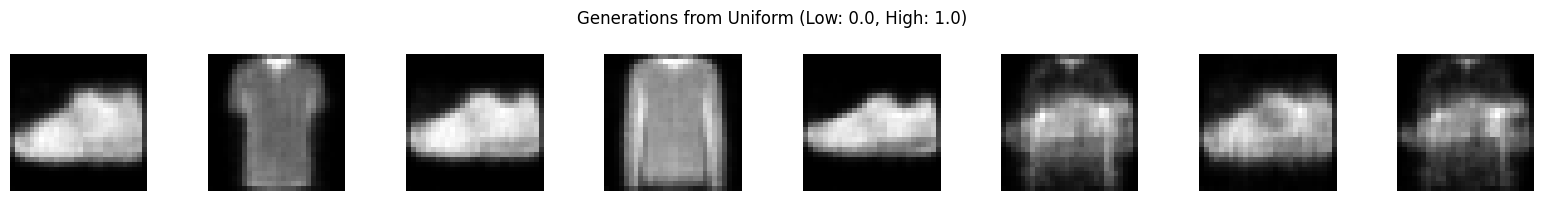

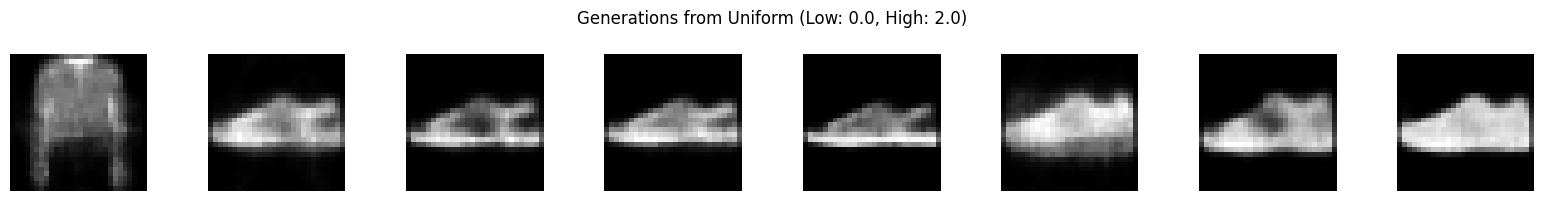

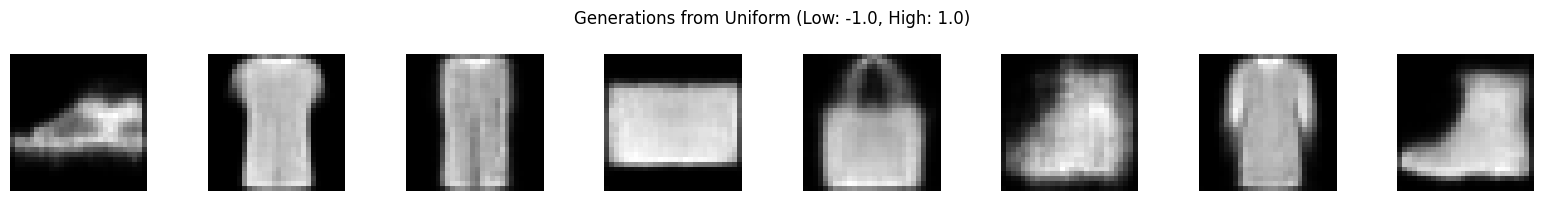

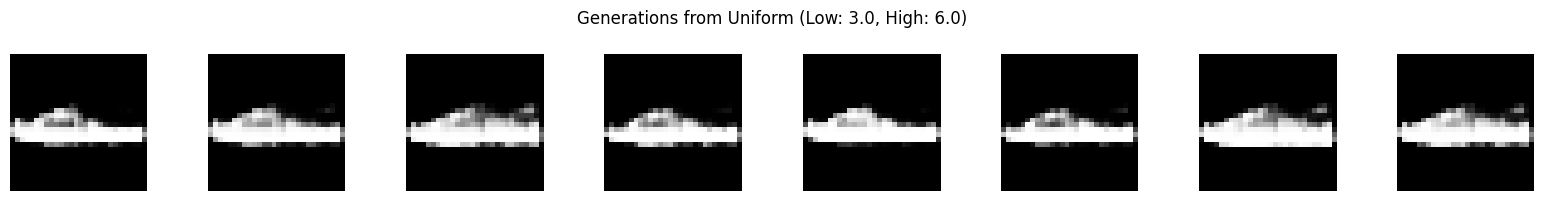

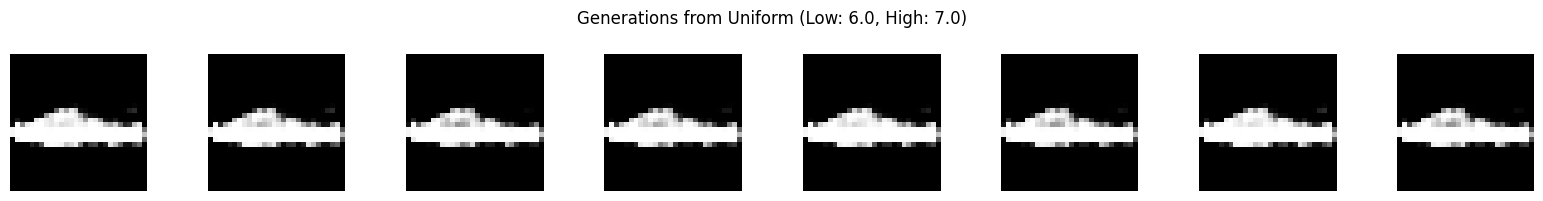

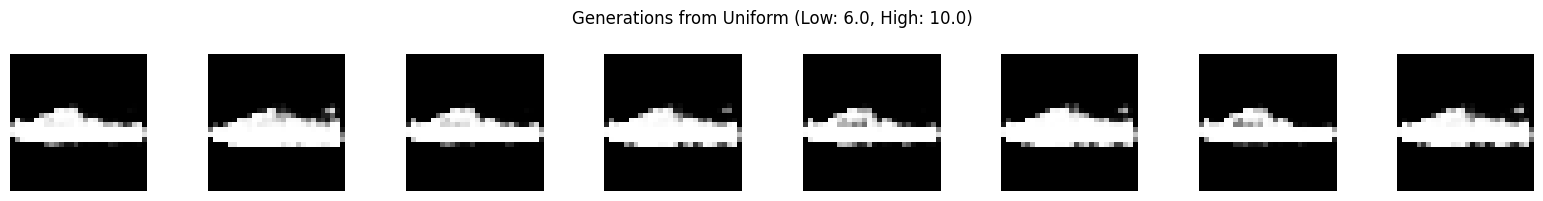

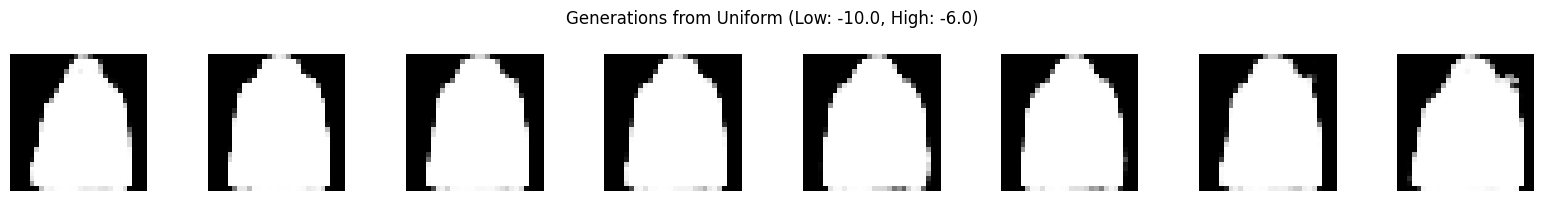

In [ ]:
def visualize_uniform_prior(model, low, high, num_samples=8, latent_dim=20):
    # Tweak sampling from a different prior for fun
    model.eval()
    with torch.no_grad():
        # Sample from a *different* prior: e.g., a wider Gaussian N(0, 4)
        # z = torch.randn(num_samples, latent_dim).to(device) * factor
        # generated_imgs = model.decode(z).cpu()

        # z = torch.distributions.laplace.Laplace(0, 1).sample((num_samples, latent_dim)).to(device)
        z = torch.distributions.uniform.Uniform(low, high).sample((num_samples, latent_dim)).to(device)
        generated_imgs = model.decode(z).cpu()

        # # Using torch.distributions (requires PyTorch 1.6+)
        # loc = torch.tensor(0.0)
        # scale = torch.tensor(1.0)
        # laplace = torch.distributions.Laplace(loc, scale)
        # z = laplace.sample((num_samples, latent_dim)).to(device)
        # generated_imgs = model.decode(z).cpu()

    # Plotting
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples*2, 2))
    for i in range(num_samples):
        axes[i].imshow(generated_imgs[i].squeeze().numpy(), cmap='gray')
        axes[i].axis('off')

    plt.suptitle(f'Generations from Uniform (Low: {low}, High: {high})')
    plt.tight_layout()
    plt.show()

# Uniform Distribution
visualize_uniform_prior(model, low=0.0, high=1.0)
visualize_uniform_prior(model, low=0.0, high=2.0)
visualize_uniform_prior(model, low=-1.0, high=1.0)
visualize_uniform_prior(model, low=3.0, high=6.0)
visualize_uniform_prior(model, low=6.0, high=7.0)
visualize_uniform_prior(model, low=6.0, high= 10.0)
visualize_uniform_prior(model, low=-10.0, high= -6.0)

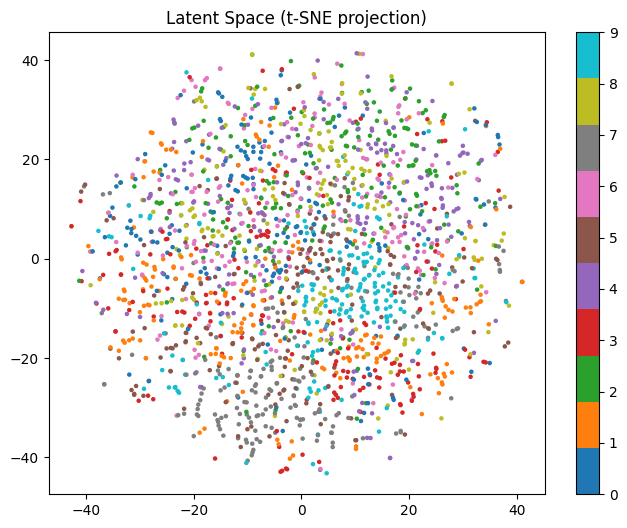

In [ ]:
from sklearn.manifold import TSNE

def visualize_latent_space(model, dataloader, num_samples=2000):
    model.eval()
    zs, labels = [], []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            mu, logvar = model.encode(images)
            z = model.reparameterize(mu, logvar)
            zs.append(z.cpu())
            labels.append(lbls)
            if len(zs) * images.size(0) > num_samples:
                break
    zs = torch.cat(zs)[:num_samples]
    labels = torch.cat(labels)[:num_samples]

    tsne = TSNE(n_components=2)
    zs_2d = tsne.fit_transform(zs)

    plt.figure(figsize=(8,6))
    plt.scatter(zs_2d[:,0], zs_2d[:,1], c=labels, cmap='tab10', s=5)
    plt.colorbar()
    plt.title("Latent Space (t-SNE projection)")
    plt.show()

# Usage
visualize_latent_space(model, test_loader)


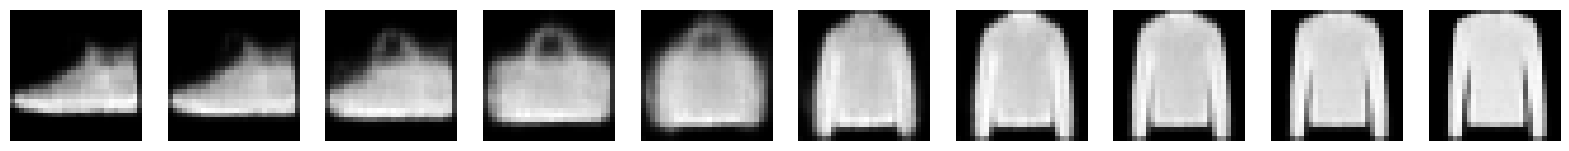

In [ ]:
def latent_interpolation(model, dataloader, steps=10):
    model.eval()
    images, _ = next(iter(dataloader))
    img1, img2 = images[0].to(device), images[1].to(device)

    with torch.no_grad():
        mu1, logvar1 = model.encode(img1.unsqueeze(0))
        mu2, logvar2 = model.encode(img2.unsqueeze(0))
        z1 = model.reparameterize(mu1, logvar1)
        z2 = model.reparameterize(mu2, logvar2)

        # Linear interpolation
        z_interp = torch.stack([z1 * (1 - t) + z2 * t for t in torch.linspace(0, 1, steps)]).to(device)
        decoded = model.decode(z_interp).cpu()

    # Plot
    fig, axes = plt.subplots(1, steps, figsize=(steps*2, 2))
    for i in range(steps):
        axes[i].imshow(decoded[i].squeeze().numpy(), cmap='gray')
        axes[i].axis('off')
    plt.show()

# Usage
latent_interpolation(model, test_loader)
